<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
from utils import *
# get_seq_lens, get_heatmaps, dataset2label, policy2label, dir_path, cell_grid, var2grid, get_dataset_len

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os, sys
import pickle
import numpy as np
from numpy import genfromtxt
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline 

np.set_printoptions(threshold=sys.maxsize)

dataset2cell_rule = {"cell49": 49, "cell9": 9, "cell35": 35}

plt.rc('font', size=10)

In [2]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap(dataset):
    policies = ["vanilla", "struct"]
    heatmaps = get_heatmaps(dataset, policies)
    
    rule_name = dataset.split("_")[0]
    
    colors = ['#263f44', '#015668',  '#ffd369'] #'#fff1cf'
    cmap=matplotlib.colors.ListedColormap(colors)
    cmap = LinearSegmentedColormap.from_list('template', colors, N=10)

    fig = plt.figure(figsize=(14,3))
    fig.set_facecolor("white")
    plt.rc('font', size=20)
    chart_cols = len(policies) + 2

    # The Rule
    cmap_bw=matplotlib.colors.ListedColormap(colors)
    cmap_bw = LinearSegmentedColormap.from_list('template', ["white", "black"], N=2)
    grid = cell_grid(dataset2cell_rule[rule_name])
    plt.subplot(1, chart_cols, 1)
    plt.xticks(np.arange(0, 20, 5, dtype=np.int))
    plt.yticks(np.arange(0, 20, 5, dtype=np.int))
    im = plt.imshow(grid[:20, :20], cmap=cmap_bw, interpolation=None)
    plt.colorbar(im,fraction=0.046, pad=0.04).set_ticks([])
    plt.ylabel("$\mathrm{Cell}("+dataset.replace("_", ",")[4:]+")$")

    # The Units
    units_map = heatmaps["units"]["vanilla"]
    plt.subplot(1, chart_cols, 2)
    plt.xticks(np.arange(0, 20, 5, dtype=np.int))
    plt.yticks([], [])
    im = plt.imshow(units_map[:20, :20], cmap=cmap, interpolation=None)
    plt.colorbar(im,fraction=0.046, pad=0.04).set_ticks([])

    # The heatmaps for policies
    for i, key in enumerate(heatmaps["actions"].keys()):
        heatmap = heatmaps["actions"][key]
        plt.subplot(1, chart_cols, i+1 + 2)
        plt.xticks(np.arange(0, 20, 5, dtype=np.int))
        plt.yticks([], [])
        im = plt.imshow(heatmap[:20, :20], cmap=cmap, interpolation=None)
        if (i < len(heatmaps["actions"].keys())-1):
            plt.colorbar(im,fraction=0.046, pad=0.04).set_ticks([])
        else:
            plt.colorbar(im,fraction=0.046, pad=0.04)

    plt.subplots_adjust(wspace=-0.33)
    plt.show()

datasets = [(it_2, it_1) for (it_1, it_2) in dataset2label.items() if it_1.split("_")[0].startswith("cell")]
interact(plot_heatmap, dataset=datasets);

Widget Javascript not detected.  It may not be installed or enabled properly.


In [18]:
## To Generate the vanilla/learned heatmap for a single cellular dataset
ds2height = {"cell9_20_20": 20, "cell9_40_40": 40, "cell35_128_110": 20, "cell35_192_128": 70, 
             "cell35_256_210":50, "cell35_348_280": 40, "cell49_128_110": 20, "cell49_192_128": 70,
             "cell49_256_200":30}


def plot_large_heatmap(dataset):
    policies = ["vanilla", "struct"]
    heatmaps = get_heatmaps(dataset, policies)
    
    colors = ['#263f44', '#015668',  '#ffd369'] #'#fff1cf'
    cmap=matplotlib.colors.ListedColormap(colors)
    cmap = LinearSegmentedColormap.from_list('template', colors, N=10)
    
    fig = plt.figure(figsize=(20,10))
    fig.set_facecolor("white")
    plt.rc('font', size=18)

    units_map = heatmaps["units"]["vanilla"]
    plt.subplot(3, 1 , 1)
    plt.xticks([], [])
    plt.ylabel("Units")
    plt.imshow(units_map[:ds2height[dataset], :200], cmap=cmap, interpolation=None)
    plt.colorbar(fraction=0.0085, pad=0.01)
    
    first = 0
    for i, key in enumerate(heatmaps["actions"].keys()):

        heatmap = heatmaps["actions"][key]
        plt.subplot(3, 1 , i+2)
    #     plt.title(policy2label[key])
        if(first==0): plt.xticks([], [])

        plt.ylabel(policy2label(key))
        plt.imshow(heatmap[:ds2height[dataset], :200], cmap=cmap, interpolation=None)
        plt.colorbar(fraction=0.0085, pad=0.01)
        first +=1

    plt.subplots_adjust(hspace=0.057)
    plt.savefig('/Users/Haddock/Desktop/plots/heat_' + dataset, bbox_inches='tight')
    plt.show()

datasets = [(it_2, it_1) for (it_1, it_2) in dataset2label.items() if it_1.split("_")[0].startswith("cell")]
interact(plot_large_heatmap, dataset=datasets);

Widget Javascript not detected.  It may not be installed or enabled properly.


In [26]:
def plot_cactus(dataset):
    if (dataset.startswith("grid")):
        policies = ["timedecode", "vanilla"]
    else:
        policies = ["struct", "vanilla"]
        
    cut_off = 1e5
    ds_lens  = list(get_dataset_len(dataset, policies).values())
    seq_lens = get_seq_lens(dataset, policies)["steps"]
        
    f = plt.figure(figsize=(9,7))
    plt.rc('font', size=34)
    f.set_facecolor("white")

    colors = ['#1b6ca8', "#d63447", '#ffd31d']
    markers = ['v', 'o']

    max_lens = 0
    for i, (name, seq) in enumerate(seq_lens.items()):
        max_lens = max(max_lens, np.max((seq)))
        seq.sort()
        seq = [item for item in seq if item <= cut_off][:200]
        
        style = "-" if (name == "vanilla") else "--"
        plt.plot(seq, label=policy2label(name), color=colors[i], linewidth=2, fillstyle='none', 
                 marker=markers[i], markersize=10, linestyle=style)

    # plt.xscale('log')
#     plt.yscale('log')
#     if (max_lens > cut_off):
#         plt.ylim(top=cut_off)
    plt.xlim(right=200)#min(200, np.max(ds_lens)))
    plt.title('')
    plt.xlabel("Problems Solved")
    plt.ylabel("Number of Steps (log-scale)")
    plt.grid(True)
    plt.legend()#loc='lower right')#, ncol=2)#, bbox_to_anchor=(1.2, 0.1))
    plt.savefig('/Users/Haddock/Desktop/plots/cactus_' + dataset, bbox_inches='tight')
    plt.show()
    

datasets = [(it_2, it_1) for (it_1, it_2) in dataset2label.items()]
interact(plot_cactus, dataset=datasets);

Widget Javascript not detected.  It may not be installed or enabled properly.


In [4]:
def plot_percentage(problem):
    if (problem == "cell_35"):
        datasets = ["cell35_128_110", "cell35_192_128", "cell35_256_210", "cell35_348_280"]
        policies = ["vanilla", 'struct']
    elif (problem == "cell_9"):
        datasets = ["cell9_20_20", "cell9_40_40"]
        policies = ["vanilla", 'struct']
    elif (problem == "cell_49"):
        datasets = ["cell49_128_110", "cell49_192_128", "cell49_256_200"]
        policies = ["vanilla", 'struct']
    elif (problem == "grid"):
        datasets = ["grid_10_5", "grid_10_9", "grid_10_12", "grid_10_14", "grid_12_14"]
        policies = ["vanilla", 'timedecode']
    elif (problem == "bvexpr"):
        datasets = ["bvexpr_5_4_8", "bvexpr_7_4_12"]
        policies = ["vanilla", 'struct']
    elif (problem == "sudoku"):
        datasets = ["sudoku_16_105", "sudoku_9_25"]
        policies = ["vanilla", 'struct']
    cap = 1e5

    f = plt.figure(figsize=(12,8))
    plt.rc('font', size=32)
    f.set_facecolor("white")

    markers = ['D', 'x', 'o', '^', 's']
    colors = ["#d63447", '#1b6ca8', '#0e9aa7', '#ffd31d', '#ff9234']

    for d_i, dataset in enumerate(datasets):
        seq_lens = get_seq_lens(dataset, policies)["steps"]


        for i, (name, seq) in enumerate(seq_lens.items()):
            seq.sort()
            seq_len = len(seq)
            seq_cap = [s for s in seq if s < cap]

            percent = np.array([[s, i/seq_len * 100] for i, s in enumerate(seq_cap)])
            percent_binned = []

            bin_marks = np.logspace(1, 5, num=10)
            bin_mark_pos = 0
            for s, p in percent:
                if(bin_marks[bin_mark_pos] + 1 < s):
                    percent_binned += [[bin_marks[bin_mark_pos], p]]
                    bin_mark_pos += 1
            percent_binned += [[percent[-1][0], percent[-1][1]]]
            percent_binned = np.array(percent_binned)

            style = "-" if (name == "vanilla") else "--"
            label = policy2label(name) + ", $\\bf{" +  dataset2label[dataset] + "}$"
            plt.plot(percent_binned[:,0], percent_binned[:,1], label=label, 
                     color=colors[d_i], marker=markers[d_i], markersize=16,
                     linewidth=3, linestyle=style)

            plt.ylim(bottom=0, top=100)
            plt.xlim(left=30, right=100000)

    plt.xscale('log')
    # plt.yscale('log')
    plt.title('')
    plt.xlabel("Number of Steps (log-scale)")
    plt.ylabel("% of Problems Solved")
    plt.grid(True)

    ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: (len(t[0]), t[0])))
    ax.legend(handles, labels, prop={'size': 14})#, loc='top left')#, bbox_to_anchor=(1, 0.17))
    # plt.legend(loc='lower right', prop={'size': 14})#, bbox_to_anchor=(1.05, 1))#, ncol=2
    plt.savefig('/Users/Haddock/Desktop/plots/percent_' + problem, bbox_inches='tight')
    plt.show()
    
interact(plot_percentage, problem=["sudoku", "cell_9", "cell_35", "cell_49", "grid", "bvexpr"]);

In [22]:
# This cell produces cactus plot for wall-clock and step_count on grid_10_12

def plot_wall_cactus(measure):
    if (measure == "Step-Count"):
        times = get_seq_lens("grid_10_12", ["timedecode"], wall_clock=False)["steps"]
        csv_ind = 1
        ylabel = "Number of Steps (log-scale)"
    else:
        times = get_seq_lens("grid_10_12", ["timedecode"], wall_clock=True)["times"]
        csv_ind = 2
        ylabel = "Wall-clock Time in seconds (log-scale)"

    # The vanilla data is stored in a csv file not a pickle
    vanilla_data = genfromtxt("/Users/Haddock/Desktop/alldata/vanilla_grid_10_12.csv", delimiter=',')
    times["vanilla"] = vanilla_data[:, csv_ind].tolist()

    print(f"SharpSAT {measure} (sum/avg): {np.sum(times['vanilla']):.1f}/{np.mean(times['vanilla']):.1f}")
    print(f"Learned  {measure} (sum/avg): {np.sum(times['timedecode']):.1f}/{np.mean(times['timedecode']):.1f}")

    f = plt.figure(figsize=(10,7))
    plt.rc('font', size=24)
    f.set_facecolor("white")

    colors = ['#1b6ca8', "#d63447", '#ffd31d']
    markers = ['v', 'o']
    
    for i, (name, time) in enumerate(times.items()):
        time.sort()

        style = "-" if (name == "vanilla") else "--"
        plt.plot(time, label=policy2label(name), color=colors[i], linewidth=2, fillstyle='none', 
                 marker=markers[i], markersize=15, linestyle=style)

    plt.xlim(left=0, right=200)
    # plt.xscale('log')
    plt.yscale('log')
    plt.title('')
    plt.xlabel("Problems Solved")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

interact(plot_wall_cactus, measure=["Wall-Clock", "Step-Count"]);

Sequence length for GridWrld(10,12)-SharpSAT (max/avg/cnt): 100001.0/93127.9/198
Sequence length for GridWrld(10,12)-Time (max/avg/cnt): 100001.0/3147.1/198
Sequence length for GridWrld(10,12)-Time+VarScore (max/avg/cnt): 100001.0/2869.0/198
Sequence length for GridWrld(10,12)-Learned (max/avg/cnt): 100001.0/65009.6/198
Sequence length for GridWrld(10,12)-Graph+Time (max/avg/cnt): 100001.0/1212.6/198
Sequence length for GridWrld(10,12)-Learned (max/avg/cnt): 100001.0/1319.5/198


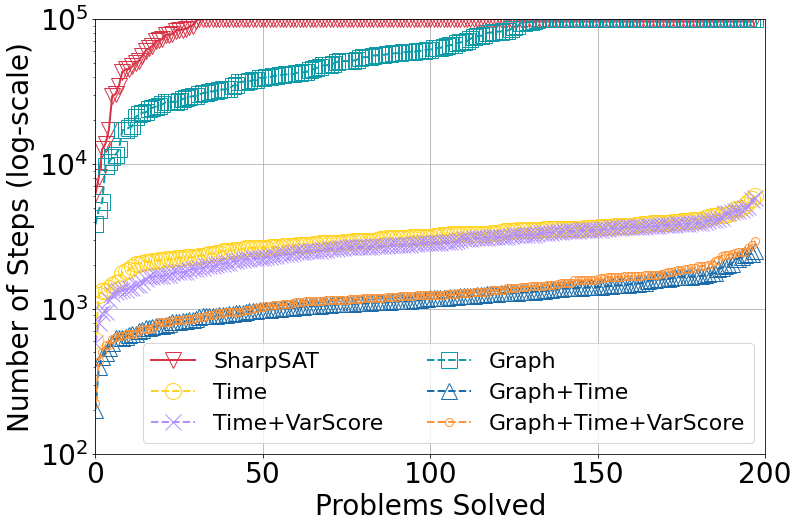

In [2]:
## This cell produces time feature's ablation plot

dataset = "grid_10_12"
policies = ["vanilla", "timeonly", "time_activity", "struct", "timestruct", "timedecode"]

f = plt.figure(figsize=(12,8))
plt.rc('font', size=28)
f.set_facecolor("white")

markers = ['v', 'o', 'x', 's', '^', '.']
colors = ["#d63447", '#ffd31d', '#B08EFD', '#0e9aa7', '#1b6ca8', '#ff9234']
# ['#1b6ca8', "#d63447", '#f0a500', '#09BB47', '#120136', '#FFF933']

seq_lens = get_seq_lens(dataset, policies)["steps"]
for i, policy in enumerate(policies):
    seq = seq_lens[policy]
    seq.sort()
#     print(policy, len(seq))
    style = "-" if (policy == "vanilla") else "--"
    plt.plot(seq, label=policy2label(policy, ablation=True), color=colors[i], linewidth=2, fillstyle='none', 
             marker=markers[i], markersize=16, linestyle=style)

plt.ylim(bottom=100, top=100000)
plt.xlim(left=0, right=200)        
# plt.xscale('log')
plt.yscale('log')
plt.title('')
plt.xlabel("Problems Solved")
plt.ylabel("Number of Steps (log-scale)")
plt.grid(True)
plt.legend(loc='lower right', prop={'size': 22}, ncol=2)#, bbox_to_anchor=(1.2, 0.1))
plt.show()

In [31]:
def plot_radar(dataset):
    if (dataset.startswith("grid")):
        policies = ["vanilla", "timedecode"]
    else:
        policies = ["vanilla", "struct"]
        
    stats = []
    for policy in policies:
        ds_dir = f"{policy}_{dataset}"

        files = [os.path.join(dir_path, ds_dir, f) for f in os.listdir(os.path.join(dir_path, ds_dir))]
        stats_list = []

        for file in files:
            infile = open(file,'rb')
            new_dict = pickle.load(infile)
            infile.close()

            stats_list.append(new_dict["stats"])

        df = pd.DataFrame(stats_list)
        means = df.mean()

        stat = list(means[['cache_miss_rate', 'num_conflicts', 'num_cashed_lookups', 
                           'avg_comp_size_stored', 'avg_comp_size_hit']].values)
        stats.append(stat)

    labels=np.array(['cache hit-rate', '1 / num conflicts', 'num cashe lookups', 
                     'avg(comp size stored)', 'avg(comp size hit)'])
    stats = np.array(stats)
    stats_normed = stats
    stats_normed[:,0] = 1 - stats[:,0] / 100
    stats_normed[:,1] = 1 - stats[:,1] / stats[:,1].max(axis=0)# 1 / (stats[:,1] + 1)
    stats_normed[:,2] = stats[:,2] / stats[:,2].max(axis=0)
    stats_normed[:,3] = stats[:,3] / stats[:,3].max(axis=0)
    stats_normed[:,4] = stats[:,4] / stats[:,4].max(axis=0)

    colors = ['#120136', '#fcbf1e', '#40bad5', '#035aa6']
    cmap=matplotlib.colors.ListedColormap(colors)
    cmap = LinearSegmentedColormap.from_list('template', colors, N=1000)
    
    fig=plt.figure(figsize=(10,7))
    fig.set_facecolor("white")
    plt.rc('font', size=30)
    matplotlib.rcParams["legend.framealpha"] = 1

    ax = fig.add_subplot(111, polar=True)   # Set polar axis
    for ind, stat in enumerate(stats_normed):
        angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
        data=np.concatenate((stat,[stat[0]]))
        angles=np.concatenate((angles,[angles[0]]))


        ax.plot(angles, data, 'o-', color=colors[ind], linewidth=2, label=policy2label(policies[ind]))
        ax.fill(angles, data, color=colors[ind], alpha=0.25)
        ax.set_thetagrids(angles * 180/np.pi, labels)
        ax.grid(True)

    ax.legend(loc='lower right', bbox_to_anchor=(1.2, 0.1))
    plt.show()


datasets = [(it_2, it_1) for (it_1, it_2) in dataset2label.items()]
interact(plot_radar, dataset=datasets);

Widget Javascript not detected.  It may not be installed or enabled properly.
